##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Adversarial example using FGSM

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/adversarial_fgsm"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/adversarial_fgsm.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/adversarial_fgsm.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/adversarial_fgsm.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial creates an *adversarial example* using the Fast Gradient Signed Method (FGSM) attack as described in [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572) by Goodfellow *et al*. This was one of the first and most popular attacks to fool a neural network. 

## What is an adversarial example?

Adversarial examples are specialised inputs created with the purpose of confusing a neural network, resulting in the misclassification of a given input. These notorious inputs are indistinguishable to the human eye, but cause the network to fail to identify the contents of the image. There are several types of such attacks, however, here the focus is on the fast gradient sign method attack, which is a *white box* attack whose goal is to ensure misclassification. A white box attack is where the attacker has complete access to the model being attacked. One of the most famous examples of an adversarial image shown below is taken from the aforementioned paper.

![Adversarial Example](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/adversarial_example.png?raw=1)

Here, starting with the image of a panda, the attacker adds small perturbations (distortions) to the original image, which results in the model labelling this image as a gibbon, with high confidence. The process of adding these perturbations is explained below.

## Fast gradient sign method
The fast gradient sign method works by using the gradients of the neural network to create an adversarial example. For an input image, the method uses the gradients of the loss with respect to the input image to create a new image that maximises the loss. This new image is called the adversarial image. This can be summarised using the following expression:
$$adv\_x = x + \epsilon*\text{sign}(\nabla_xJ(\theta, x, y))$$

where 

*   adv_x : Adversarial image.
*   x : Original input image.
*   y : Original input label.
*   $\epsilon$ : Multiplier to ensure the perturbations are small.
*   $\theta$ : Model parameters.
*   $J$ : Loss.

An intriguing property here, is the fact that the gradients are taken with respect to the input image. This is done because the objective is to create an image that maximises the loss. A method to accomplish this is to find how much each pixel in the image contributes to the loss value, and add a perturbation accordingly. This works pretty fast because it is easy to find how each input pixel contributes to the loss by using the chain rule and finding the required gradients. Hence, the gradients are taken with respect to the image. In addition, since the model is no longer being trained (thus the gradient is not taken with respect to the trainable variables, i.e., the model parameters), and so the model parameters remain constant. The only goal is to fool an already trained model.

So let's try and fool a pretrained model. In this tutorial, the model is [MobileNetV2](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications/MobileNetV2) model, pretrained on [ImageNet](http://www.image-net.org/).

In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

Let's load the pretrained MobileNetV2 model and the ImageNet class names.

In [3]:
pretrained_model = tf.keras.models.load_model('../model_medium_b32.h5')

# ImageNet labels
prediction_labels = ['esca', 'healthy']

Evaluation of the model

In [ ]:
x_test = np.load('dataset/esca_dataset_xtest_model_medium2.npy').reshape(None, 320, 180, 3)
y_test = np.load('dataset/esca_dataset_ytest_model_medium2.npy')

test_loss, test_acc = pretrained_model.evaluate(x_test, y_test, verbose=2)
print(test_loss)
print(test_acc)

In [4]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.image.resize(image, (320, 180))
  # image = tf.cast(image, tf.int32)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_image_label(probs):
  return tf.argmax(probs, axis = -1)

def fromTrainingFormatToPrintingFormat(image):
  i = tf.image.resize(image, (180, 320))
  return tf.cast(i, tf.int32)

## Original image
Let's use an image from the test folder of the dataset and create adversarial examples from it. The first step is to preprocess it so that it can be fed as an input to our model.

In [7]:
# image_raw = tf.io.read_file('test/healthy/healthy_1.jpg')
image_raw = tf.io.read_file('../test/esca/esca_1.jpg')
image = tf.image.decode_image(image_raw)

processed_image = preprocess(image)
image_probs = pretrained_model.predict(processed_image)
print(image_probs)

indice_predicted_class = get_image_label(image_probs[0])
class_confidence = image_probs[0][indice_predicted_class]
image_class = prediction_labels[indice_predicted_class]

image_to_print = fromTrainingFormatToPrintingFormat(processed_image)

[[1. 0.]]


Let's have a look at the image.

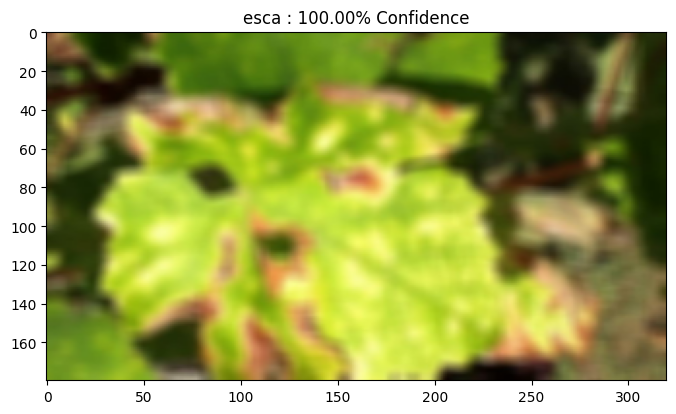

In [8]:
plt.figure()
plt.imshow(image_to_print[0])  # To change [-1, 1] to [0,1]
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## Create the adversarial image

### Implementing fast gradient sign method
The first step is to create perturbations which will be used to distort the original image resulting in an adversarial image. As mentioned, for this task, the gradients are taken with respect to the image.

In [9]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

The resulting perturbations can also be visualised.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[[[[255. 255. 255.]
   [  0.   0. 255.]
   [  0. 255.   0.]
   ...
   [  0. 255.   0.]
   [255. 255.   0.]
   [255.   0.   0.]]

  [[255.   0. 255.]
   [  0.   0. 255.]
   [  0. 255. 255.]
   ...
   [  0. 255.   0.]
   [255. 255.   0.]
   [255.   0.   0.]]

  [[255.   0. 255.]
   [255. 255. 255.]
   [  0.   0. 255.]
   ...
   [  0. 255.   0.]
   [  0. 255.   0.]
   [  0. 255.   0.]]

  ...

  [[  0. 255. 255.]
   [  0.   0. 255.]
   [  0.   0. 255.]
   ...
   [  0. 255.   0.]
   [  0. 255.   0.]
   [255. 255.   0.]]

  [[  0. 255. 255.]
   [  0. 255.   0.]
   [  0.   0. 255.]
   ...
   [  0. 255. 255.]
   [  0. 255. 255.]
   [  0. 255.   0.]]

  [[  0. 255.   0.]
   [  0.   0.   0.]
   [255.   0. 255.]
   ...
   [  0. 255.   0.]
   [  0.   0.   0.]
   [  0. 255.   0.]]]], shape=(1, 320, 180, 3), dtype=float32)


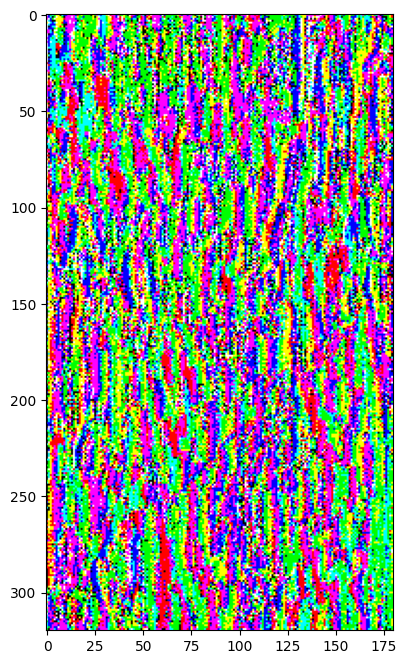

In [59]:
# Get the input label of the image.
healthy_index = 1
label = tf.one_hot(healthy_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(processed_image, label)

perturbations = tf.clip_by_value(perturbations, 0, 1)
perturbations = perturbations * 255
print(perturbations)
# for i in range(0, 320):
#     for j in range(0, 180):
#         for k in range(0, 3):
#             if perturbations[0][i][j][k] == 1:
#                 perturbations[0][i][j][k] = 255
#             else:
#                 perturbations[0][i][j][k] = 0

plt.imshow(perturbations[0])

Let's try this out for different values of epsilon and observe the resultant image. You'll notice that as the value of epsilon is increased, it becomes easier to fool the network. However, this comes as a trade-off which results in the perturbations becoming more identifiable.

In [50]:
def display_images(image_tensor, description):

  image_probs = pretrained_model.predict(image_tensor)
  indice_label = get_image_label(image_probs)
  label = prediction_labels[indice_label[0]]
  confidence = image_probs[0][indice_label[0]]
  image_to_print = fromTrainingFormatToPrintingFormat(image_tensor)

  plt.figure()
  plt.imshow(image_to_print[0])
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence*100))
  plt.show()

tf.Tensor(
[[[[123.        76.05556   55.88889 ]
   [136.33333   91.333336  62.333336]
   [161.21527  114.21528   71.65972 ]
   ...
   [ 36.        48.        12.      ]
   [ 36.        46.        11.      ]
   [ 36.        46.        11.      ]]

  [[123.        76.05556   55.88889 ]
   [135.5       90.5       61.208336]
   [160.47916  113.47917   70.923615]
   ...
   [ 36.        48.        12.      ]
   [ 36.        46.        11.      ]
   [ 36.        46.        11.      ]]

  [[123.        77.        54.      ]
   [134.5       89.5       58.5     ]
   [160.02084  112.93056   71.111115]
   ...
   [ 36.        48.        12.      ]
   [ 36.        46.        11.      ]
   [ 36.        46.        11.      ]]

  ...

  [[115.       153.94444   29.11111 ]
   [112.72917  150.72916   29.729166]
   [108.       149.        31.      ]
   ...
   [118.75     113.125     63.      ]
   [116.1458   109.1458    63.145798]
   [120.81946  113.81946   67.81946 ]]

  [[116.       154.94444   30.1111

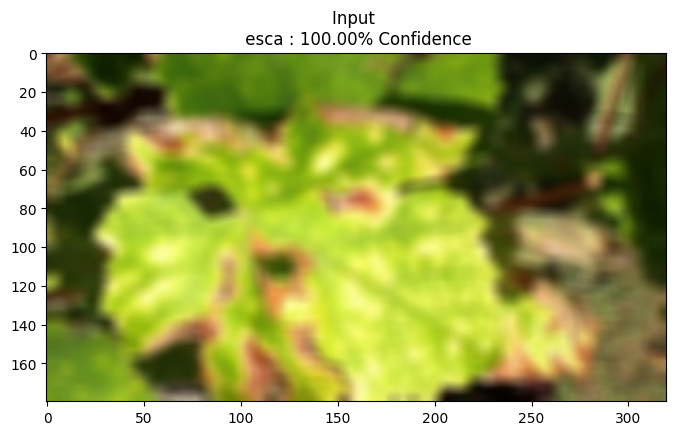

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[[[[125.55      78.60556   58.43889 ]
   [136.33333   91.333336  64.88334 ]
   [161.21527  116.76528   71.65972 ]
   ...
   [ 36.        50.55      12.      ]
   [ 38.55      48.55      11.      ]
   [ 38.55      46.        11.      ]]

  [[125.55      76.05556   58.43889 ]
   [135.5       90.5       63.758335]
   [160.47916  116.029175  73.47362 ]
   ...
   [ 36.        50.55      12.      ]
   [ 38.55      48.55      11.      ]
   [ 38.55      46.        11.      ]]

  [[125.55      77.        56.55    ]
   [137.05      92.05      61.05    ]
   [160.02084  112.93056   73.66112 ]
   ...
   [ 36.        50.55      12.      ]
   [ 36.        48.55      11.      ]
   [ 36.        48.55      11.      ]]

  ...

  [[115.       156.49445   31.66111 ]
   [112.72917  150.72916   32.279167]
   [108.       149.        33.55    ]
   ...
   [118.75     115.675     63.      ]
   [116.1458   111.6958    63.145798]
   [123.36946  116.36946   67.81946 ]]

  [[116.       157.49445   32.6611

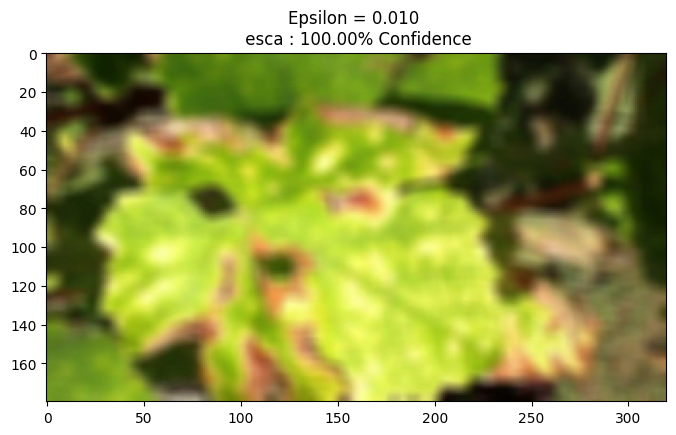

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[[[[148.5      101.55556   81.388885]
   [136.33333   91.333336  87.833336]
   [161.21527  139.71527   71.65972 ]
   ...
   [ 36.        73.5       12.      ]
   [ 61.5       71.5       11.      ]
   [ 61.5       46.        11.      ]]

  [[148.5       76.05556   81.388885]
   [135.5       90.5       86.708336]
   [160.47916  138.97917   96.423615]
   ...
   [ 36.        73.5       12.      ]
   [ 61.5       71.5       11.      ]
   [ 61.5       46.        11.      ]]

  [[148.5       77.        79.5     ]
   [160.       115.        84.      ]
   [160.02084  112.93056   96.611115]
   ...
   [ 36.        73.5       12.      ]
   [ 36.        71.5       11.      ]
   [ 36.        71.5       11.      ]]

  ...

  [[115.       179.44444   54.61111 ]
   [112.72917  150.72916   55.229164]
   [108.       149.        56.5     ]
   ...
   [118.75     138.625     63.      ]
   [116.1458   134.6458    63.145798]
   [146.31946  139.31946   67.81946 ]]

  [[116.       180.44444   55.6111

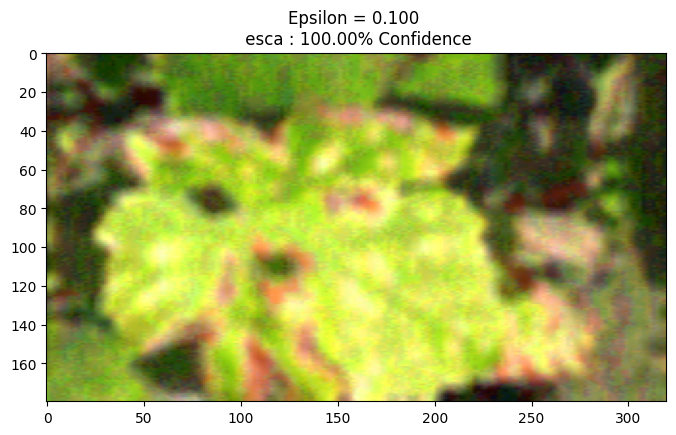

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[[[[161.25     114.30556   94.138885]
   [136.33333   91.333336 100.583336]
   [161.21527  152.46527   71.65972 ]
   ...
   [ 36.        86.25      12.      ]
   [ 74.25      84.25      11.      ]
   [ 74.25      46.        11.      ]]

  [[161.25      76.05556   94.138885]
   [135.5       90.5       99.458336]
   [160.47916  151.72917  109.173615]
   ...
   [ 36.        86.25      12.      ]
   [ 74.25      84.25      11.      ]
   [ 74.25      46.        11.      ]]

  [[161.25      77.        92.25    ]
   [172.75     127.75      96.75    ]
   [160.02084  112.93056  109.361115]
   ...
   [ 36.        86.25      12.      ]
   [ 36.        84.25      11.      ]
   [ 36.        84.25      11.      ]]

  ...

  [[115.       192.19444   67.361115]
   [112.72917  150.72916   67.979164]
   [108.       149.        69.25    ]
   ...
   [118.75     151.375     63.      ]
   [116.1458   147.3958    63.145798]
   [159.06946  152.06946   67.81946 ]]

  [[116.       193.19444   68.3611

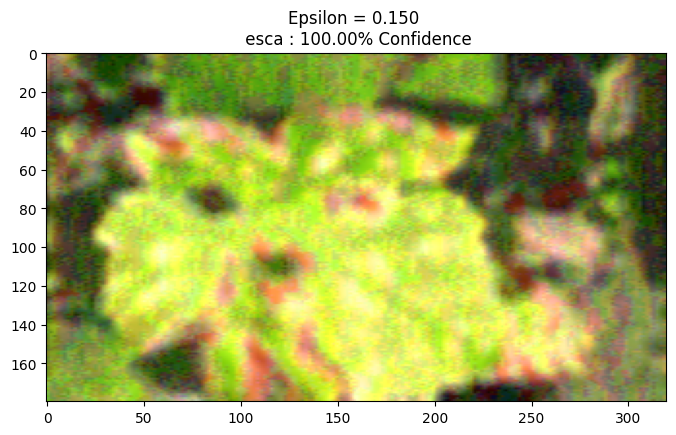

In [62]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input') for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = processed_image + eps * perturbations
  display_images(adv_x, descriptions[i])

## Next steps

Now that you know about adversarial attacks, try this out on different datasets and different architectures. You may also create and train your own model, and then attempt to fool it using the same method. You can also try and see how the confidence in predictions vary as you change epsilon.

Though powerful, the attack shown in this tutorial was just the start of research into adversarial attacks, and there have been multiple papers creating more powerful attacks since then. In addition to adversarial attacks, research has also led to the creation of defenses, which aims at creating robust machine learning models. You may review this [survey paper](https://arxiv.org/abs/1810.00069) for a comprehensive list of adversarial attacks and defences.

For many more implementations of adversarial attacks and defenses, you may want to see the adversarial example library [CleverHans](https://github.com/tensorflow/cleverhans).